<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_NLP_Project/blob/main/%5BNLP_12%5DCreate_a_cool_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [NLP_12]Create a cool chatbot

## 1. Import 및 라이브러리 다운로드

In [1]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.2 MB/s 


In [2]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash


--2022-10-19 01:14:56--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-10-19 01:14:56--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5be7c997d9468523f79fb975e3.dl.dropboxusercontent.com/cd/0/get/BvFeYw65jcfHZNui5NZi8EB0Zzlxlwm4Qx4ll1uCPDPBn4HPLI9yJnBjY_emAxuwxS14kfQjEp2bYG1smTK8LeW24VkBu12j42u3ebRECURpaqU0Xv0WkBmPFlMgE0ecqqTZM95wWVzo-5ZgMy532fZDyjqwsSL4lgeXw43O-8ZjmEbIR5cjcE11OEgn_mKIUHs/file?dl=1# [following]
--2022-10-19 01:14:57--  https://uc5be7c997d9468523f79fb975e3.dl.dropboxusercontent.com/cd/0/get/BvFeYw65jc

In [120]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from konlpy.tag import Mecab
from collections import Counter
import re
import os
import random
import math
import urllib.request
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

mecab = Mecab()

## 2. 데이터 다운로드
준비하기 단계에서 심볼릭 링크를 생성했다면 아래 파일이 ChatbotData .csv라는 이름으로 저장되어 있을거예요. csv 파일을 읽는 데에는 pandas 라이브러리가 적합합니다. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장하세요!
- https://github.com/songys/Chatbot_data

- 일반 https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv 링크로는 오류가 생김 
- 이유는 웹 페이지 자체를 링크하기 때문임 그래서 raw를 선택하여 데이터만 있는 링크를 가지고 학습을 진행해야 함

In [121]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


- https://stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data

In [122]:
questions = []
answers = []
for i in range(len(train_data)):
  # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
  questions.append(str(train_data['Q'].values[i]))
  answers.append(str(train_data['A'].values[i]))

In [123]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [124]:
print(questions[100])
print(answers[100])

거지됐어
밥 사줄 친구를 찾아 보세요~


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 15
텍스트의 평균 길이 : 3.587414361837097
요약의 최소 길이 : 1
요약의 최대 길이 : 21
요약의 평균 길이 : 3.6936479742874058


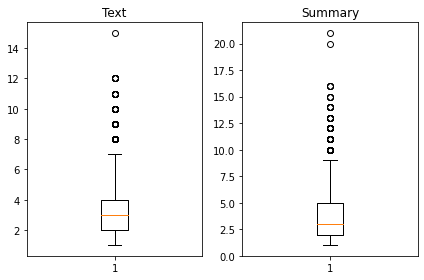

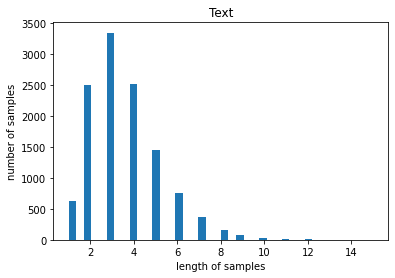

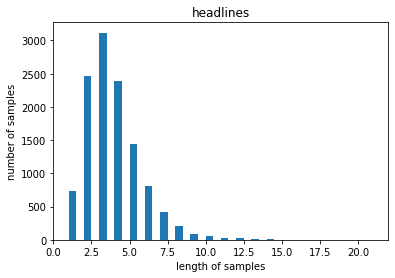

In [125]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in questions]
headlines_len = [len(s.split()) for s in answers]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [126]:
assert len(questions) == len(answers)

cleaned_corpus = list(set(zip(questions, answers)))

In [127]:
for pair in cleaned_corpus[:10]:
    print(pair)
    print('pair 0 :',pair[0])
    print('pair 1 :',pair[1])
    print(len(pair[0]))

('누워 있는데 잠이 안 와', '고민이 있나 봐요.')
pair 0 : 누워 있는데 잠이 안 와
pair 1 : 고민이 있나 봐요.
13
('멍 때리는 중', '잠깐씩 멍때리는것도 정신건강에 좋아요.')
pair 0 : 멍 때리는 중
pair 1 : 잠깐씩 멍때리는것도 정신건강에 좋아요.
7
('어떤 사람 만나야해?', '내가 나답게 살 수 있도록 해줄 수 있는 사람인 것 같아요.')
pair 0 : 어떤 사람 만나야해?
pair 1 : 내가 나답게 살 수 있도록 해줄 수 있는 사람인 것 같아요.
11
('수면양말 포근포근 따뜻하다', '잠이 솔솔와서 수면양말인가봐요.')
pair 0 : 수면양말 포근포근 따뜻하다
pair 1 : 잠이 솔솔와서 수면양말인가봐요.
14
('머리따로 마음따로 몸따로', '머리랑 가슴이 가끔 따로 놀죠.')
pair 0 : 머리따로 마음따로 몸따로
pair 1 : 머리랑 가슴이 가끔 따로 놀죠.
13
('슬픈 예감대로 되어가는 현실', '슬픈 예감은 틀린 적이 없죠.')
pair 0 : 슬픈 예감대로 되어가는 현실
pair 1 : 슬픈 예감은 틀린 적이 없죠.
15
('아무것도 하고 싶지 않으면서 아무거나 하고 싶어', '행복해지기 위해 무엇인가를 하고 있는 게 좋을 거예요.')
pair 0 : 아무것도 하고 싶지 않으면서 아무거나 하고 싶어
pair 1 : 행복해지기 위해 무엇인가를 하고 있는 게 좋을 거예요.
26
('커피 안 마시면 일을 못해', '커피도 좋지만 차도 마셔보세요.')
pair 0 : 커피 안 마시면 일을 못해
pair 1 : 커피도 좋지만 차도 마셔보세요.
14
('필름 카메라 샀어', '색감 참 좋겠네요.')
pair 0 : 필름 카메라 샀어
pair 1 : 색감 참 좋겠네요.
9
('짝남이랑 썸 탈 것 같애.', '좋은 결실 맺길 바랍니다.')
pair 0 : 짝남이랑 썸 탈 것 같애.
pair 1 : 좋은 결실 맺길 바랍니다.
14


## 3. 데이터 정제
아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요.

1. 영문자의 경우, 모두 소문자로 변환합니다.
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!

In [128]:
def preprocess_sentence(sentence):
  sentence = sentence.lower()
  sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  sentence = mecab.morphs(sentence)

  return sentence 

## 4. 데이터 토큰화
토큰화에는 KoNLPy의 mecab 클래스를 사용합니다.

아래 조건을 만족하는 build_corpus() 함수를 구현하세요!

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.

In [129]:
def build_corpus(cleaned_corpus):
  que_corpus = []
  ans_corpus = []
  for pair in cleaned_corpus:#[:num_examples]:
    que = preprocess_sentence(pair[0])
    ans = preprocess_sentence(pair[1])
    if len(que) <= 15  and len(ans) <= 15: 
      que_corpus.append(que)
      ans_corpus.append(ans)

  return que_corpus, ans_corpus

In [130]:
que_corpus, ans_corpus = build_corpus(cleaned_corpus)

In [131]:
print(que_corpus[0])
print(ans_corpus[0])

print(len(que_corpus))
print(len(ans_corpus))

['누워', '있', '는데', '잠', '이', '안', '와']
['고민', '이', '있', '나', '봐요', '.']
10961
10961


## 5. Augmentation
우리에게 주어진 데이터는 1만 개가량으로 적은 편에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? Lexical Substitution을 실제로 적용해 보도록 하겠습니다.

아래 링크를 참고하여 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다. Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!

- https://github.com/Kyubyong/wordvectors

다운로드한 모델을 활용해 데이터를 Augmentation 하세요! 앞서 정의한 lexical_sub() 함수를 참고하면 도움이 많이 될 겁니다.

Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

- 참고 자료
  - https://github.com/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_8%5DAnalyzing_the_Sensibility_of_Film_Review_Texts.ipynb
  - https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-14%EC%9D%BC%EC%B0%A8-word2vec-%EC%8B%A4%EC%8A%B52-8e518a358b6c

In [132]:
word2vec_file_path_lstm = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_file_path_lstm)
ko_model.most_similar('사과')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('사죄', 0.5442899465560913),
 ('충고', 0.4946415424346924),
 ('질문', 0.48838865756988525),
 ('해명', 0.48268449306488037),
 ('대답', 0.4778830409049988),
 ('선처', 0.4665257930755615),
 ('질타', 0.4546084403991699),
 ('발언', 0.4542806148529053),
 ('회답', 0.45340797305107117),
 ('고소', 0.45193421840667725)]

In [133]:
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

- 이 부분때문에 조금 시간이 남비됨 문제가 생기면 print()로 찍어서 확인하며 해결하면 빠름
- type이 계속 None로 뜸 -> 런타임 초기화 체크하기

In [134]:
print(str(que_corpus[100]))
test = lexical_sub(que_corpus[100], ko_model)
print(type(test))
print(test.split())

['구', '썸남', '보', '고', '싶', '어', '.']
<class 'str'>
['구', '썸남', '보', '기에', '싶', '어', '.']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


In [135]:
def Augmentation_model(que_corpus , ans_corpus, ko_model):
    new_que_corpus = []
    new_ans_corpus = []

    for i in tqdm(range(len(que_corpus))):
        new_que = lexical_sub(que_corpus[i], ko_model)
        new_ans = lexical_sub(ans_corpus[i], ko_model)

        if new_que is not None: 
            new_que_corpus.append(new_que.split())
            new_ans_corpus.append(ans_corpus[i])
        
        if new_ans is not None:
            new_ans_corpus.append(new_ans.split())
            new_que_corpus.append(que_corpus[i])
          
    print(new_que_corpus[:100])
    print(new_ans_corpus[:100])

    return new_que_corpus, new_ans_corpus

In [136]:
new_que_corpus, new_ans_corpus = Augmentation_model(que_corpus , ans_corpus, ko_model)

  0%|          | 0/10961 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


[['누워', '있', '는데', '깨어나', '이', '안', '와'], ['누워', '있', '는데', '잠', '이', '안', '와'], ['멍', '찌르', '는', '중'], ['멍', '때리', '는', '중'], ['머리', '따로', '마음', '따로', '몸', '별도'], ['머리', '따로', '마음', '따로', '몸', '따로'], ['슬픈', '예감', '대로', '되', '어서', '가', '는', '현실'], ['슬픈', '예감', '대로', '되', '어', '가', '는', '현실'], ['커피', '안', '마시', '면', '일', '을', '못하', '해'], ['커피', '안', '마시', '면', '일', '을', '못', '해'], ['필름', '카메라', '샀', '어'], ['짝', '남', '이랑', '썸', '아크', '것', '같', '애', '.'], ['짝', '남', '이랑', '썸', '탈', '것', '같', '애', '.'], ['바크르', '도', '기술', '인가', '봐'], ['아부', '도', '기술', '인가', '봐'], ['유부남', '을', '좋아하', '게', '됐', '어', '는데'], ['유부남', '을', '좋아하', '게', '됐', '어', '.'], ['가짜', '친구', '사귀', '고', '싶', '어'], ['진짜', '친구', '사귀', '고', '싶', '어'], ['이젠', '진짜', '끝', '인가', '봐'], ['내', '친구', '랑', '내', '짝', '남', '이', '서로', '좋아하', '는', '것', '똑같', '아', '.'], ['내', '친구', '랑', '내', '짝', '남', '이', '서로', '좋아하', '는', '것', '같', '아', '.'], ['아침', '은', '결재', '받', '아야지'], ['이사', '가', '불쌍히', '전학', '가', '게', '됐', '어'], ['이사', '가', '서', '전학'

In [137]:
print(len(new_que_corpus))
print(len(new_ans_corpus))

18945
18945


In [138]:
que_corpus = que_corpus + new_que_corpus
ans_corpus = ans_corpus + new_ans_corpus

In [139]:
print(len(que_corpus))
print(len(ans_corpus))

29906
29906


## 6. 데이터 벡터화
타겟 데이터인 ans_corpus 에 <start> 토큰과 <end> 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 ans_corpus 는 list 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!

1. 위 소스를 참고하여 타겟 데이터 전체에 <start> 토큰과 <end> 토큰을 추가해 주세요!

챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것이겠죠. 앞서 배운 것처럼 이는 
 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

2. 특수 토큰을 더함으로써 ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 enc_train 과 dec_train 을 얻으세요!

In [140]:
temp_corpus = []
for sample_data in ans_corpus:
  temp_corpus.append(["<start>"] + sample_data + ["<end>"])

ans_corpus = temp_corpus

In [141]:
# def tokenize(corpus):
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
#     tokenizer.fit_on_texts(corpus)

#     tensor = tokenizer.texts_to_sequences(corpus)

#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=20 ,padding='post')

#     return tensor, tokenizer

In [142]:
# enc_train, enc_tokenizer  = tokenize(que_corpus)
# dec_train, dec_tokenizer  = tokenize(temp_corpus)

In [143]:
# BATCH_SIZE = 64
# train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=BATCH_SIZE)

- LMS 노드에서 사용하는 encode_as_ids는 SentencePiece 버전이므로 아래 참조링크에서 mecab로 토큰화한 것은 어떻게 벡터화를 해야할지 참고하고 적용해라
- 참고자료 
  - https://github.com/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_8%5DAnalyzing_the_Sensibility_of_Film_Review_Texts.ipynb

In [144]:
voc_data = que_corpus + ans_corpus

words = np.concatenate(voc_data).tolist()
counter = Counter(words)
counter = counter.most_common(30000-2)
vocab = ['<pad>', '<unk>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for word, index in word_to_index.items()}

In [145]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in sentence]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<unk>' for index in encoded_sentence[1:])  

def vectorize(corpus, word_to_index):
    data = []
    for sen in corpus:
        sen = get_encoded_sentence(sen, word_to_index)
        data.append(sen)
    return data

que_train = vectorize(que_corpus, word_to_index)
ans_train = vectorize(ans_corpus, word_to_index)

print(len(que_train))
print(len(ans_train))

print(que_train)
print(ans_train)

29906
29906
[[2753, 17, 26, 327, 5, 41, 169], [1179, 1385, 7, 160], [2467, 1720, 4482, 523, 6, 31], [287, 801, 51, 801, 426, 801], [601, 1721, 341, 56, 11, 10, 7, 404], [453, 41, 475, 42, 60, 9, 107, 15], [1886, 3940, 832, 11], [92, 79, 183, 90, 729, 43, 34, 125, 2], [2612, 22, 1462, 164, 154], [2073, 9, 252, 24, 226, 11, 2], [191, 45, 224, 12, 35, 11], [328, 191, 122, 164, 154], [64, 45, 117, 64, 92, 79, 5, 232, 252, 7, 43, 34, 23, 2], [96, 18, 3941, 93, 1548], [777, 10, 134, 2754, 10, 24, 226, 11], [4483, 953, 52, 393], [932, 17, 7, 29, 5, 14, 119], [1500, 19, 55, 1043, 2], [96, 10, 7, 2308, 27, 92, 79, 5, 17, 26, 2], [499, 22, 86, 138], [4484, 125, 143, 6201], [1806, 2202, 177, 15, 184, 20], [96, 1463, 99, 1386, 48, 69, 10, 56, 63, 105], [219, 5, 209, 1974], [201, 475, 12, 6202, 1092, 3942], [153, 12, 627, 992], [70, 45, 10, 2309, 27, 567, 15], [2755, 37, 575, 116], [47, 6, 7, 13, 6, 372, 155, 39, 11], [141, 1250, 31, 4790, 4791, 23], [191, 720, 25, 31], [337, 351, 5, 372, 73, 5, 66

In [146]:
enc_train = tf.keras.preprocessing.sequence.pad_sequences(que_train,maxlen=20, padding='pre')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(ans_train, maxlen=20, padding='post')

In [147]:
print(enc_train)
print(dec_train)

[[   0    0    0 ...    5   41  169]
 [   0    0    0 ... 1385    7  160]
 [   0    0    0 ...  523    6   31]
 ...
 [   0    0    0 ... 4252  112 2901]
 [   0    0    0 ... 1033  272  154]
 [   0    0    0 ... 1033   21  154]]
[[   3  172    5 ...    0    0    0]
 [   3  673  254 ...    0    0    0]
 [   3  327    5 ...    0    0    0]
 ...
 [   3 1177   44 ...    0    0    0]
 [   3 1119    9 ...    0    0    0]
 [   3 1119    9 ...    0    0    0]]


In [148]:
enc_train, enc_test, dec_train, dec_test = \
train_test_split(enc_train, dec_train, test_size=0.2)

enc_train_size = len(enc_train)
dec_train_size = len(dec_train)
enc_test_size = len(enc_test)
dec_test_size = len(dec_test)
print("한국어 train Size:", enc_train_size)
print("영어 train Size:", dec_train_size)
print("한국어 test Size:", enc_test_size)
print("영어 test Size:", dec_test_size)
print('한국어 shape : ', enc_train.shape)
print('영어 shape : ', dec_train.shape)

한국어 train Size: 23924
영어 train Size: 23924
한국어 test Size: 5982
영어 test Size: 5982
한국어 shape :  (23924, 20)
영어 shape :  (23924, 20)


## 7. 훈련하기
앞서 번역 모델을 훈련하며 정의한 Transformer 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! 가장 멋진 답변과 모델의 하이퍼파라미터를 제출하시면 됩니다.

In [92]:

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [93]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [94]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [95]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [96]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [97]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [98]:

class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [99]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [100]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [101]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=enc_train_size,
    tgt_vocab_size=dec_train_size,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512

In [102]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [103]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)


In [104]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [105]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [106]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

In [107]:
# EPOCHS = 3

# for epoch in range(EPOCHS):
#     total_loss = 0
    
#     dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
#     tqdm_bar = tqdm(total=dataset_count)
#     for step, (enc_batch, dec_batch) in enumerate(train_dataset):
#         batch_loss, enc_attns, dec_attns, dec_enc_attns = \
#         train_step(enc_batch,
#                     dec_batch,
#                     transformer,
#                     optimizer)

#         total_loss += batch_loss
        
#         tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
#         tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
#         tqdm_bar.update()

In [108]:
def get_decoded_sentence(encoded_sentence, idx2word):
    return ' '.join(idx2word[index] if index in idx2word else '<UNK>' for index in encoded_sentence[1:]) 


def get_decoded_sentences(encoded_sentences, idx2word):
    return [get_decoded_sentence(encoded_sentence, idx2word) for encoded_sentence in encoded_sentences]

In [161]:
def evaluate(sentence, model):
    #print(sentence)
    sentence = preprocess_sentence(sentence)
    pieces = sentence # SP에서는 encode_as_pieces를 사용하여 서브 워드 시퀀스로 변환했으나 여기선 그대로 받아오면 됨
    tokens = get_encoded_sentence(pieces, word_to_index) # sentencePiece에서는 encode_as_ids를 사용하여 인덱스화시킴
   # print(tokens)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    
    output = tf.expand_dims([word_to_index["<start>"]], 0) 
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        
      
        if word_to_index["<end>"] == predicted_id:
            result = get_decoded_sentence(ids, index_to_word) # sp의 decode_ids를 위에서 구현한 함수로 대체
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, index_to_word)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

def translate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    return result

In [162]:
examples = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

In [163]:
for example in examples:
    translate(example, transformer)


지루하다, 놀러가고 싶어.
[1642, 6, 31, 335, 206, 241, 10, 12, 35, 11, 2]
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 이 아프 네요 .
오늘 일찍 일어났더니 피곤하다.
[96, 623, 1614, 550, 517, 6, 31, 2]
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 도 아니 썸남 기 이 답답 좋 예요 .
간만에 여자친구랑 데이트 하기로 했어.
[2469, 70, 45, 117, 253, 6, 61, 99, 58, 11, 2]
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 의 헤어진지 을 멋있 좋 같 상대 .
집에 있는다는 소리야.
[176, 27, 17, 980, 632, 85, 2]
Input: 집에 있는다는 소리야.
Predicted translation: 은 것 들 이 식이 을 좋 예요 .


## 8. 성능 측정하기
챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표입니다. 올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 calculate_bleu() 함수도 적용해 보세요.

In [114]:
# 아래 두 문장을 바꿔가며 테스트 해보세요
reference = "많 은 자연어 처리 연구자 들 이 트랜스포머 를 선호 한다".split()
candidate = "적 은 자연어 학 개발자 들 가 트랜스포머 을 선호 한다 요".split()

print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", sentence_bleu([reference], candidate))

원문: ['많', '은', '자연어', '처리', '연구자', '들', '이', '트랜스포머', '를', '선호', '한다']
번역문: ['적', '은', '자연어', '학', '개발자', '들', '가', '트랜스포머', '을', '선호', '한다', '요']
BLEU Score: 8.190757052088229e-155


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [115]:
print("1-gram:", sentence_bleu([reference], candidate, weights=[1, 0, 0, 0]))
print("2-gram:", sentence_bleu([reference], candidate, weights=[0, 1, 0, 0]))
print("3-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 1, 0]))
print("4-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 0, 1]))

1-gram: 0.5
2-gram: 0.18181818181818182
3-gram: 2.2250738585072626e-308
4-gram: 2.2250738585072626e-308


In [116]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.5
BLEU-2: 0.18181818181818182
BLEU-3: 0.010000000000000004
BLEU-4: 0.011111111111111112

BLEU-Total: 0.05637560315259291


In [230]:
def eval_bleu_single(model, src_sentence, tgt_sentence, verbose=True):
    print("1",src_sentence)
    src_tokens = get_encoded_sentence(src_sentence, index_to_word)
    tgt_tokens = get_encoded_sentence(tgt_sentence, index_to_word)
    print("2",src_tokens)

    new_src_tokens = []
    new_tgt_tokens = []
        
    for word in src_tokens:
        if word !='<pad>' and word !='<unk>' and word !='<start>' and word !='<end>':
            new_src_tokens.append(word)

    for word in tgt_tokens:
        if word !='<pad>' and word !='<unk>' and word !='<start>' and word !='<end>':
            new_tgt_tokens.append(word)

    if (len(new_src_tokens) > 20): return None
    if (len(new_tgt_tokens) > 20): return None
    print("3",new_tgt_tokens)
    print("4",new_src_tokens)
    print("5",type(' '.join(new_tgt_tokens)))
    reference = ' '.join(new_tgt_tokens) # lower이 적용안되서 list타입을 str로 변환 : https://blockdmask.tistory.com/m/573 
    candidate = translate(' '.join(new_src_tokens), model)

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", ' '.join(new_src_tokens))
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

In [231]:
test_idx = 0

eval_bleu_single(transformer, enc_test[test_idx], dec_test[test_idx])

1 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   21 1287   12   35   11]
2 ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '나', '인정받', '고', '싶', '어']
3 ['지금', '도', '충분히', '잘', '하', '고', '있', '어요', '.']
4 ['나', '인정받', '고', '싶', '어']
5 <class 'str'>
나 인정받 고 싶 어
[21, 1287, 12, 35, 11]
Input: 나 인정받 고 싶 어
Predicted translation: 편의점 많 게 하 나 친구 .
Source Sentence:  나 인정받 고 싶 어
Model Prediction:  편의점 많 게 하 나 친구 .
Real:  지금 도 충분히 잘 하 고 있 어요 .
Score: 0.062989



0.06298906001241376

In [227]:
def eval_bleu(model, src_sentences, tgt_sentence, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

In [229]:
eval_bleu(transformer,enc_test[::20], dec_test[::20], verbose=True)

  0%|          | 0/300 [00:00<?, ?it/s]

1 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   21 1287   12   35   11]
2 ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '나', '인정받', '고', '싶', '어']
3 ['지금', '도', '충분히', '잘', '하', '고', '있', '어요', '.']
4 ['나', '인정받', '고', '싶', '어']
5 <class 'str'>
나 인정받 고 싶 어
[21, 1287, 12, 35, 11]
Input: 나 인정받 고 싶 어
Predicted translation: 편의점 많 게 하 나 친구 .
Source Sentence:  ['나', '인정받', '고', '싶', '어']
Model Prediction:  편의점 많 게 하 나 친구 .
Real:  지금 도 충분히 잘 하 고 있 어요 .
Score: 0.062989

1 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 5111   78  257   37  248]
2 ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '시누', '좀', '이상', '한', '듯']
3 ['아직', '이', '라면', '더', '살펴보', '세요', '.']
4 ['시누', '좀', '이상', '한', '듯']
5 <class 'str'>
시누 좀 이상 한 듯
[5111, 78, 257, 37, 248]
Input: 시누 좀 이상